In [1]:
import torch
from torch_geometric.nn import GCNConv, ChebConv  # noqa
import time
import networkx as nx
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from importlib import reload
from best_params import best_params_dict #, default_args
import data as dt

In [2]:
%matplotlib inline

In [3]:
reload(dt)

<module 'data' from '/home/huy/graph-neural-pde/src/data.py'>

In [4]:
from GNN import GNN
from run_GNN import get_optimizer, train, test

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# opt = {'self_loop_weight': 1, 'leaky_relu_slope': 0.2, 'heads': 2, 'K': 10,
#         'attention_norm_idx': 0, 'simple': True, 'alpha': 0, 'alpha_dim': 'sc', 'beta_dim': 'sc',
#         'hidden_dim': 64, 'block': 'attention', 'function': 'laplacian', 'alpha_sigmoid': True, 'augment': False, 'adjoint': False,
#         'tol_scale': 70, 'time': 20, 'input_dropout': 0.5, 'dropout': 0.2, 'method': 'dopri5', 'optimizer':'adam', 'lr':0.008,
#         'decay':0.007, 'epoch':30, 'kinetic_energy':None, 'jacobian_norm2':None, 'total_deriv':None, 'directional_penalty':None}
best_opt = best_params_dict['Cora']
opt = { **best_opt}

In [6]:
# dataset = dt.get_dataset('Cora', '../data', use_lcc=True)
dataset = dt.get_dataset(opt, '../data', opt['not_lcc'])
# dataset = dt.get_dataset({'dataset':'Cora', 'rewiring' : None}, '/content/graph-neural-pde/data', use_lcc=True) 
print(dataset.data.num_nodes, dataset.data.num_edges)

2485 10138


/home/huy/miniconda3/envs/grand/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
model, dat = GNN(opt, dataset, device).to(device), dataset.data.to(device)

In [8]:
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = get_optimizer(opt['optimizer'], parameters, lr=opt['lr'], weight_decay=opt['decay'])

In [9]:
best_val_acc = test_acc = best_epoch = 0
for epoch in range(1, opt['epoch']):
    start_time = time.time()

    loss = train(model, optimizer, dat)
    train_acc, val_acc, tmp_test_acc = test(model, dat)

    if val_acc > best_val_acc:
      best_val_acc = val_acc
      test_acc = tmp_test_acc
      best_epoch = epoch
    log = 'Epoch: {:03d}, Runtime {:03f}, Loss {:03f}, forward nfe {:d}, backward nfe {:d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(
      log.format(epoch, time.time() - start_time, loss, model.fm.sum, model.bm.sum, train_acc, best_val_acc, test_acc))
    print('best val accuracy {:03f} with test accuracy {:03f} at epoch {:d}'.format(best_val_acc, test_acc, best_epoch))

/home/huy/miniconda3/envs/grand/lib/python3.11/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


Epoch: 001, Runtime 0.993464, Loss nan, forward nfe 50, backward nfe 0, Train: 0.0000, Val: 0.0000, Test: 0.0000
best val accuracy 0.000000 with test accuracy 0.000000 at epoch 0
Epoch: 002, Runtime 0.138441, Loss nan, forward nfe 150, backward nfe 0, Train: 0.0000, Val: 0.0000, Test: 0.0000
best val accuracy 0.000000 with test accuracy 0.000000 at epoch 0
Epoch: 003, Runtime 0.136540, Loss nan, forward nfe 250, backward nfe 0, Train: 0.0000, Val: 0.0000, Test: 0.0000
best val accuracy 0.000000 with test accuracy 0.000000 at epoch 0
Epoch: 004, Runtime 0.132594, Loss nan, forward nfe 356, backward nfe 0, Train: 0.0000, Val: 0.0000, Test: 0.0000
best val accuracy 0.000000 with test accuracy 0.000000 at epoch 0
Epoch: 005, Runtime 0.130278, Loss nan, forward nfe 462, backward nfe 0, Train: 0.0000, Val: 0.0000, Test: 0.0000
best val accuracy 0.000000 with test accuracy 0.000000 at epoch 0
Epoch: 006, Runtime 0.131240, Loss nan, forward nfe 568, backward nfe 0, Train: 0.0000, Val: 0.0000, 

In [10]:
attention = model.odeblock.odefunc.attention_weights
edges = model.odeblock.odefunc.edge_index
print('edges shape: {}, attention shape: {}'.format(edges.shape, attention.shape))

edges shape: torch.Size([2, 12623]), attention shape: torch.Size([12623, 8])


In [11]:
print(attention.min(), attention.mean(), attention.max())

tensor(0.0059, device='cuda:0') tensor(0.1969, device='cuda:0') tensor(0.5000, device='cuda:0')


In [14]:
atts = attention.detach().cpu().numpy()[:,0]
print(atts.shape)

(12623,)


CPU times: user 26.4 ms, sys: 941 µs, total: 27.3 ms
Wall time: 34.4 ms


(array([2366., 3939., 3975., 1635.,    0.,  708.,    0.,    0.,    0.,
           0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

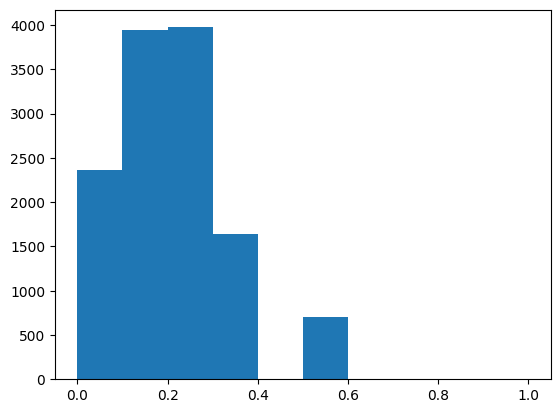

In [15]:
%%time
plt.hist(atts, bins=np.linspace(0,1,11))

CPU times: user 27.5 ms, sys: 1.42 ms, total: 29 ms
Wall time: 26 ms


(array([  0.,   0.,   0.,   0.,   0., 169.,   0.,   0.,   0.,   0.]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 ]),
 <BarContainer object of 10 artists>)

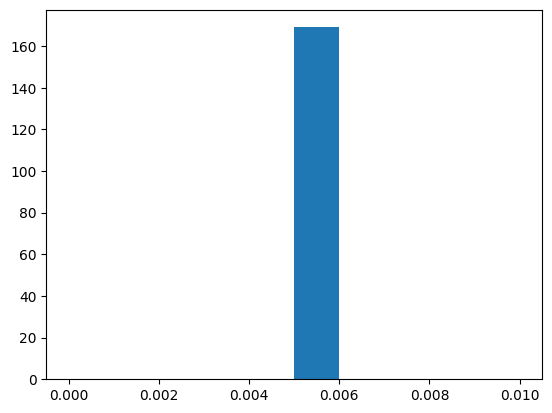

In [16]:
%%time
plt.hist(atts, bins=np.linspace(0,0.01,11))

In [17]:
print(attention.shape, edges.shape)

torch.Size([12623, 8]) torch.Size([2, 12623])


In [18]:
labels = dataset.data.y
print(len(labels))

2485


/home/huy/miniconda3/envs/grand/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [19]:
def construct_graph(edges, attention=None, threshold=0.01):
    if isinstance(edges, torch.Tensor):
        edges = edges.cpu().numpy()
    if attention is not None:
        edges = edges[:, attention > threshold]
    edge_list = zip(edges[0], edges[1])
    g = nx.Graph(edge_list)
    return g

In [20]:
edges = model.odeblock.odefunc.edge_index
g = construct_graph(edges)
print(g.edges([32]))
print(g.number_of_edges(), g.number_of_nodes(), nx.number_connected_components(g))

[(32, 387), (32, 790), (32, 791), (32, 1063), (32, 32)]
7554 2485 1


In [21]:
g.remove_edges_from([(32, 387), (32, 790), (32, 791), (32, 1063), (32, 32)])
print(g.number_of_edges(), g.number_of_nodes(), nx.number_connected_components(g))

7549 2485 2


In [22]:
delete_edges = edges[:, attention[:, 0].detach().cpu().numpy() < 0.1]
print(delete_edges.shape)

torch.Size([2, 2366])


In [46]:
def remove_edges(g, edges, attention, threshold):
    if isinstance(edges, torch.Tensor):
        edges = edges.cpu().numpy()
    if isinstance(attention, torch.Tensor):
        attention = attention.detach().cpu().numpy()
    print(edges.shape, attention.shape, threshold)
    print((attention < threshold).shape)
    if attention.ndim == 2:
        delete_edges = edges[:, attention[:, 0] < threshold]
    else:
        delete_edges = edges[:, attention < threshold]
    print('deleting {} edges'.format(delete_edges.shape[1]))
    edge_list = list(zip(delete_edges[0], delete_edges[1]))
    g.remove_edges_from(edge_list)
    print(g.number_of_edges(), g.number_of_nodes(), nx.number_connected_components(g))
    return g

In [47]:
g = remove_edges(g, edges, attention, threshold=0.02)
# print(g.number_of_edges(), g.number_of_nodes())

(2, 12623) (12623,) 0.02
(12623,)
deleting 389 edges
7165 2485 38


In [48]:
g.edges([2])

EdgeDataView([(2, 1), (2, 296), (2, 1334), (2, 1531), (2, 2)])

In [49]:
list(g.edges)[0:10]

[(575, 0),
 (575, 1726),
 (575, 575),
 (0, 1722),
 (0, 2400),
 (0, 0),
 (1722, 852),
 (1722, 2400),
 (1722, 1722),
 (2400, 1068)]

In [50]:
print(g.number_of_edges(), g.number_of_nodes())

7165 2485


In [51]:
nx.number_connected_components(g)

38

In [52]:
print(edges.shape, attention.shape)

torch.Size([2, 12623]) torch.Size([12623])


In [53]:
np.linspace(1,0,20)

array([1.        , 0.94736842, 0.89473684, 0.84210526, 0.78947368,
       0.73684211, 0.68421053, 0.63157895, 0.57894737, 0.52631579,
       0.47368421, 0.42105263, 0.36842105, 0.31578947, 0.26315789,
       0.21052632, 0.15789474, 0.10526316, 0.05263158, 0.        ])

In [54]:
np.linspace(0,1,20)

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [55]:
for threshold in np.linspace(0,0.01,20):
    edges = model.odeblock.odefunc.edge_index
    g = construct_graph(edges)
    attention = model.odeblock.odefunc.edge_weight
    g = remove_edges(g, edges, attention, threshold)
    comps = nx.number_connected_components(g)
    print('{} remaining edges. {} connected components at threshold {}'.format(g.number_of_edges(), comps, threshold))

(2, 12623) (12623,) 0.0
(12623,)
deleting 0 edges
7554 2485 1
7554 remaining edges. 1 connected components at threshold 0.0
(2, 12623) (12623,) 0.0005263157894736842
(12623,)
deleting 0 edges
7554 2485 1
7554 remaining edges. 1 connected components at threshold 0.0005263157894736842
(2, 12623) (12623,) 0.0010526315789473684
(12623,)
deleting 0 edges
7554 2485 1
7554 remaining edges. 1 connected components at threshold 0.0010526315789473684
(2, 12623) (12623,) 0.0015789473684210526
(12623,)
deleting 0 edges
7554 2485 1
7554 remaining edges. 1 connected components at threshold 0.0015789473684210526
(2, 12623) (12623,) 0.002105263157894737
(12623,)
deleting 0 edges
7554 2485 1
7554 remaining edges. 1 connected components at threshold 0.002105263157894737
(2, 12623) (12623,) 0.002631578947368421
(12623,)
deleting 0 edges
7554 2485 1
7554 remaining edges. 1 connected components at threshold 0.002631578947368421
(2, 12623) (12623,) 0.003157894736842105
(12623,)
deleting 0 edges
7554 2485 1
7

In [56]:
for threshold in np.linspace(0,0.01,20):
    edges = model.odeblock.odefunc.edge_index
    g = construct_graph(edges)
    attention = model.odeblock.odefunc.attention_weights[:,0]  # just using one head for now.
    g = remove_edges(g, edges, attention, threshold)
    comps = nx.number_connected_components(g)
    print('{} remaining edges. {} connected components at threshold {}'.format(g.number_of_edges(), comps, threshold))

(2, 12623) (12623,) 0.0
(12623,)
deleting 0 edges
7554 2485 1
7554 remaining edges. 1 connected components at threshold 0.0
(2, 12623) (12623,) 0.0005263157894736842
(12623,)
deleting 0 edges
7554 2485 1
7554 remaining edges. 1 connected components at threshold 0.0005263157894736842
(2, 12623) (12623,) 0.0010526315789473684
(12623,)
deleting 0 edges
7554 2485 1
7554 remaining edges. 1 connected components at threshold 0.0010526315789473684
(2, 12623) (12623,) 0.0015789473684210526
(12623,)
deleting 0 edges
7554 2485 1
7554 remaining edges. 1 connected components at threshold 0.0015789473684210526
(2, 12623) (12623,) 0.002105263157894737
(12623,)
deleting 0 edges
7554 2485 1
7554 remaining edges. 1 connected components at threshold 0.002105263157894737
(2, 12623) (12623,) 0.002631578947368421
(12623,)
deleting 0 edges
7554 2485 1
7554 remaining edges. 1 connected components at threshold 0.002631578947368421
(2, 12623) (12623,) 0.003157894736842105
(12623,)
deleting 0 edges
7554 2485 1
7

In [57]:
print(len(g.edges), len(g.nodes), g.number_of_nodes())

7385 2485 2485


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

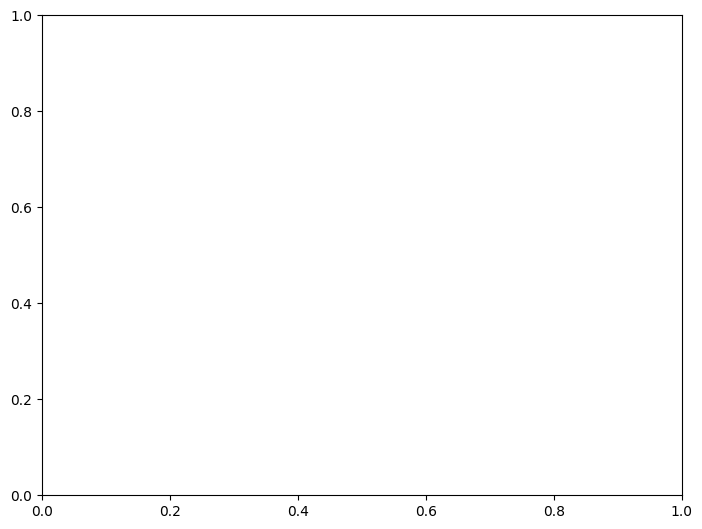

In [60]:
%%time

nx.draw(g, with_labels=False, font_weight='bold', node_size=5, node_color=labels)

In [61]:
# nx.connected_components(g)
print('connected: {}, n_components: {}, directed: {}'.format(nx.is_connected(g), nx.number_connected_components(g), g.is_directed()))

connected: False, n_components: 9, directed: False


In [62]:
type(atts)
atts.shape
len(g.edges)

7385

In [63]:
g.edges = g.edges[att]

NameError: name 'att' is not defined

In [64]:
ccs = [c for c in sorted(nx.connected_components(g), key=len, reverse=True)]

In [65]:
len(ccs[0])

2473

In [66]:
g0 = g.subgraph(ccs[0])

In [67]:
print(len(g0.edges), len(g0.nodes), g0.number_of_nodes())

7370 2473 2473


In [68]:
cc_idx = list(ccs[0])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

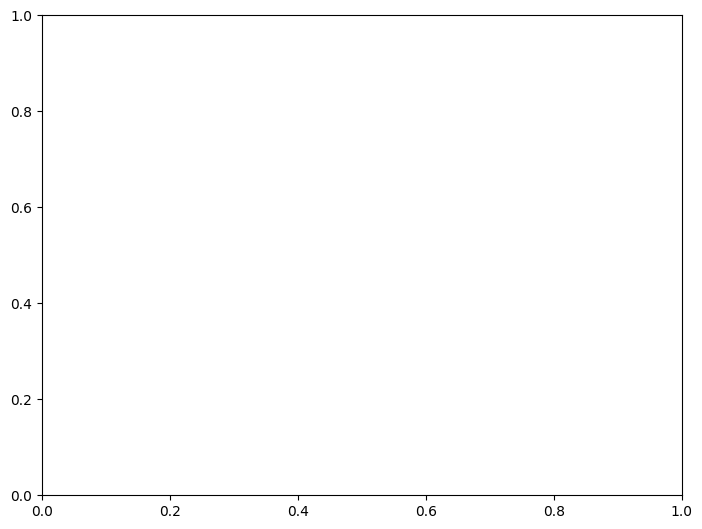

In [69]:
%%timeit
nx.draw(g0, with_labels=False, font_weight='bold', node_size=5, node_color=labels[cc_idx])

In [ ]:
plt.savefig("path.png")